**Tugas Deep Learning Kelompok 9**

Anggota Kelompok :
*   Adinda Salsabilla (2005319)
*   Alif Faturahman Firdaus (2107377)
*   Farah Balqist (2007339)
*   Sukma Julianti (2009110)
*   Wildan Mauli Darojat (2106330)

Sumber : Bean Leaves Spot Detection

https://www.tensorflow.org/datasets/catalog/beans

Bean adalah dataset gambar kacang yang diambil di lapangan menggunakan kamera smartphone. Terdiri dari 3 kelas yaitu 2 kelas disease dan kelas healthy. Disease yang digambarkan termasuk Agular leaf Spot dan Bean Rust. Kumpulan data ini adalah gambar daun yang diambil di lapangan di berbagai distrik di Uganda oleh laboratorium AI Makerere bekerja sama dengan National Crops Resources Research Institute (NaCRRI), badan nasional yang bertanggung jawab atas penelitian pertanian di Uganda.

Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# download dataset
import pathlib
dataset_url = "https://storage.googleapis.com/ibeans/train.zip"
data_dir_keras = tf.keras.utils.get_file(origin=dataset_url, extract=True, archive_format='zip')

143812152/143812152 [==============================] - 2s 0us/step


In [ ]:
data_dir = '/root/.keras/datasets/train'
data_dir = pathlib.Path(data_dir)

In [ ]:
print(data_dir) #melihat directory

/root/.keras/datasets/train


In [ ]:
print(type(data_dir))

<class 'pathlib.PosixPath'>


Cek jumlah instance

In [ ]:
#jumlah instance dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Jumlah instance : {}".format(image_count))

Jumlah instance : 1034


Untuk memeriksa apakah data sudah tersimpan di cloud


In [ ]:
ls /root/.keras/datasets/

train/  train.zip


Memeriksa banyaknya folder directory

In [ ]:
import os
list_dir = [os.path.basename(x) for x in data_dir.iterdir() if x.is_dir()]
print("Jumlah class: {} ".format(len(list_dir)))
print("Jumlah instance per class")
for x in list_dir:
  print("{} = {} ".format(x,len(list(data_dir.glob('{}/*.jpg'.format(x))))))

Jumlah class: 3 
Jumlah instance per class
angular_leaf_spot = 345 
bean_rust = 348 
healthy = 341 


In [ ]:
x = list(data_dir.glob('*')); # list banyaknya dir yg ada di folder, 3 : banyaknya folder/kelas
class_count = len(x)
print(class_count)
print(x)

3
[PosixPath('/root/.keras/datasets/train/angular_leaf_spot'), PosixPath('/root/.keras/datasets/train/bean_rust'), PosixPath('/root/.keras/datasets/train/healthy')]


In [ ]:
print(type(data_dir))

<class 'pathlib.PosixPath'>


Dataset ini memiliki 3 directory sesuai kelas : bean_rust, angular_leaf_spot, healthy. Berikut cara memeriksa salah satu gambarnya pada directory angular_leaf_spot

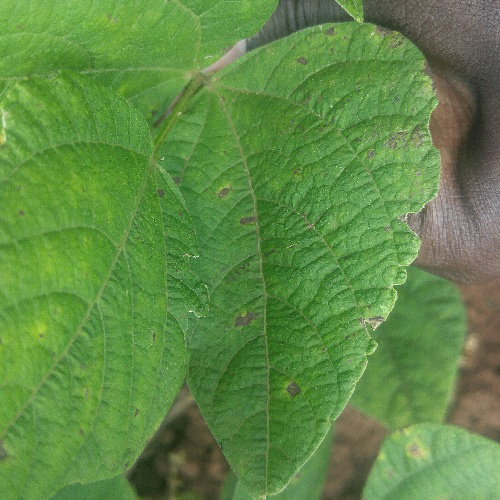

In [ ]:
angular_leaf_spot = list(data_dir.glob('angular_leaf_spot/*'))
PIL.Image.open(str(angular_leaf_spot[0]))

Memeriksa salah satu gambar pada directory bean_rust



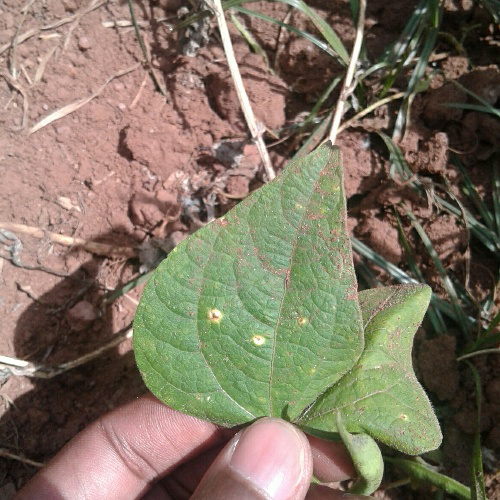

In [ ]:
bean_rust = list(data_dir.glob('bean_rust/*'))
PIL.Image.open(str(bean_rust[0]))

Memeriksa salah satu gambar pada directory healthy

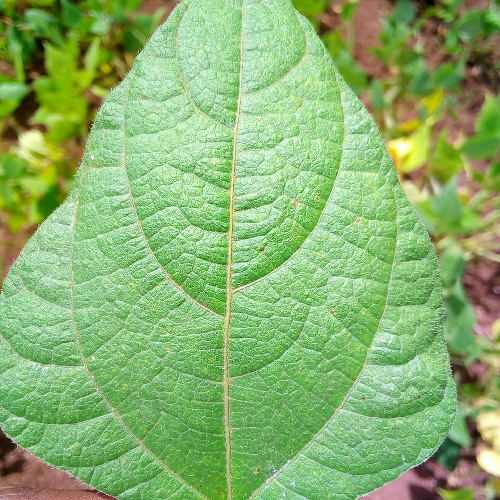

In [ ]:
healthy = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(healthy[0]))

Menentukan batch_size

In [ ]:
batch_size = 32 # ukuran atau jumlah sampel data yang nantinya akan disebarkan melalui Neural Network
img_height = 180 # ukuran tinggi image
img_width = 180 # ukuran lebar image

Menyiapkan data training

In [ ]:
# menggunakan library dari keras.utils
# langsung mempersiapkan dataset dari directory
# train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.
Using 828 files for training.


In [ ]:
train_ds # untuk menampilkan data train yang akan digunakan

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Siapkan data validasi untuk memeriksa kinerja model

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.
Using 206 files for validation.


Melihat nama class

In [ ]:
class_names = train_ds.class_names
print(class_names)

['angular_leaf_spot', 'bean_rust', 'healthy']


Menampilkan preview dataset training menggunakan matplotlib

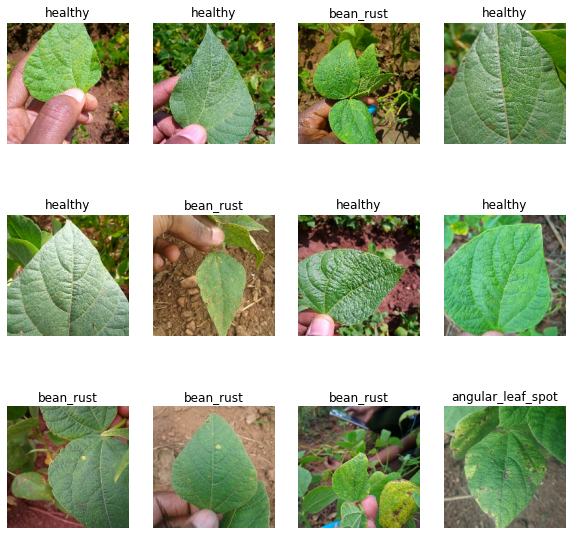

In [ ]:
# lihat dataset training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1) # 3 baris, 4 kolom
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Memperlihatkan shape untuk data training

In [ ]:
# 32 per batch, 180x180 pixel, warna 3 (RGB)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Set cache buffer untuk meningkatkan efisiensi training

In [ ]:
#agar kinerja bagus
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Normalisasikan nilai RGB dengan *layer rescaling*

In [ ]:
# normalisasi nilai RGB
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# nilai dari [0 sd 255] menjadi [0 sd 1]
print(np.min(first_image), np.max(first_image))

0.0 0.99854773


##Arsitektur Deep Learning

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Layer pertama untuk *rescaling* untuk normalisasi RGB. Layer selanjutnya adalah *Conv2D*, yang berisi filter untuk mendeteksi fitur. Pada line 5, 16 adalah jumlah filter dan 3 adalah ukuran filter (3x3), padding=same artinya padding diisi dengan nilai 0, activation adalah 'relu'. Relu merupakan fungsi matematis yang menentukan output berdasarkan input pada neural network. Terkait line 6, Max pooling adalah teknik pada CNN untuk mereduksi dimensi dan mengekstrak fitur utama. Pada line 11, Layer flatten digunakan dalam CNN untuk "meratakan" input multidimensi ke dalam vektor tunggal. Kemudian pada line 12 dan 13 ialah Dense atau fully connected layer menghubungkan semua input ke output dengan bobot.


Compile struktur setelah arsitektur CNN didefinisikan.

In [ ]:
# adam adalah optimizer untuk proses train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Melihat ringkasan arsitektural neural network dengan syntax summary()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Proses training

In [ ]:
# epoch memerlukan waktu cukup lama
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 39s 1s/step - loss: 1.0434 - accuracy: 0.4928 - val_loss: 0.8135 - val_accuracy: 0.6553
Epoch 2/10
26/26 [==============================] - 27s 1s/step - loss: 0.7529 - accuracy: 0.6932 - val_loss: 0.7434 - val_accuracy: 0.6359
Epoch 3/10
26/26 [==============================] - 28s 1s/step - loss: 0.6165 - accuracy: 0.7319 - val_loss: 0.8093 - val_accuracy: 0.5971
Epoch 4/10
26/26 [==============================] - 30s 1s/step - loss: 0.4964 - accuracy: 0.7983 - val_loss: 0.6696 - val_accuracy: 0.7136
Epoch 5/10
26/26 [==============================] - 27s 1s/step - loss: 0.3974 - accuracy: 0.8430 - val_loss: 0.9264 - val_accuracy: 0.6019
Epoch 6/10
26/26 [==============================] - 27s 1s/step - loss: 0.2914 - accuracy: 0.8901 - val_loss: 0.6924 - val_accuracy: 0.6796
Epoch 7/10
26/26 [==============================] - 28s 1s/step - loss: 0.2015 - accuracy: 0.9372 - val_loss: 0.7154 - val_accuracy: 0.6845
Epoch 8/10
26/26 [==

Plot Training

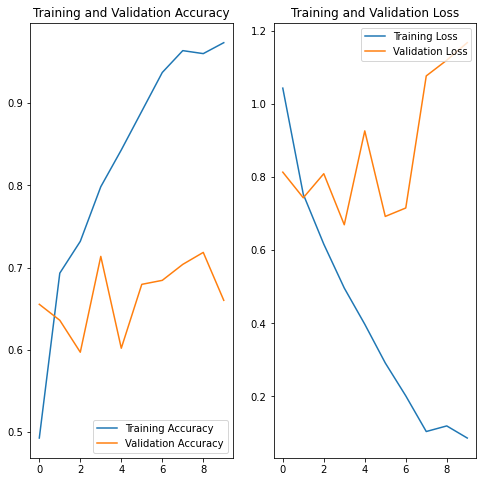

In [ ]:
# plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Hasil plot training di atas adalah overfit, yang mana dapat dilihat pada akurasi data training hasilnya lebih baik daripada data validasinya. Overfitting dapat ditangani dengan melakukan augmentasi data training dimana data yang sama secara random posisinya sedikit diubah.

Penanganan overfitting dengan augmentasi data training

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualisasikan beberapa contoh augmentasi

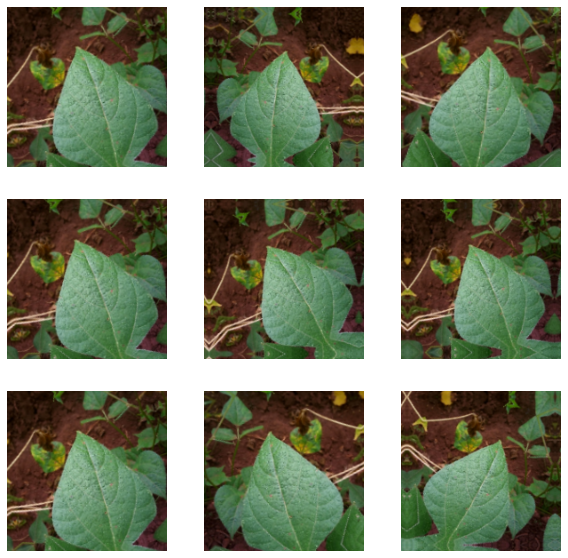

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Menambahkan dropout untuk mengurangi overfitting

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compile ulang

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Melihat ringkasan arsitektur dengan summary()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Pengulangan training

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
26/26 [==============================] - 34s 1s/step - loss: 1.1536 - accuracy: 0.4010 - val_loss: 0.9246 - val_accuracy: 0.5825
Epoch 2/15
26/26 [==============================] - 31s 1s/step - loss: 0.8464 - accuracy: 0.6002 - val_loss: 0.9037 - val_accuracy: 0.5680
Epoch 3/15
26/26 [==============================] - 33s 1s/step - loss: 0.8140 - accuracy: 0.6316 - val_loss: 0.7693 - val_accuracy: 0.6748
Epoch 4/15
26/26 [==============================] - 33s 1s/step - loss: 0.6960 - accuracy: 0.7029 - val_loss: 1.1254 - val_accuracy: 0.6359
Epoch 5/15
26/26 [==============================] - 31s 1s/step - loss: 0.7320 - accuracy: 0.6848 - val_loss: 0.6920 - val_accuracy: 0.6990
Epoch 6/15
26/26 [==============================] - 31s 1s/step - loss: 0.6620 - accuracy: 0.7198 - val_loss: 0.6290 - val_accuracy: 0.6990
Epoch 7/15
26/26 [==============================] - 33s 1s/step - loss: 0.6531 - accuracy: 0.7258 - val_loss: 0.6028 - val_accuracy: 0.7039
Epoch 8/15
26/26 [==

Plot setelah perbaikan

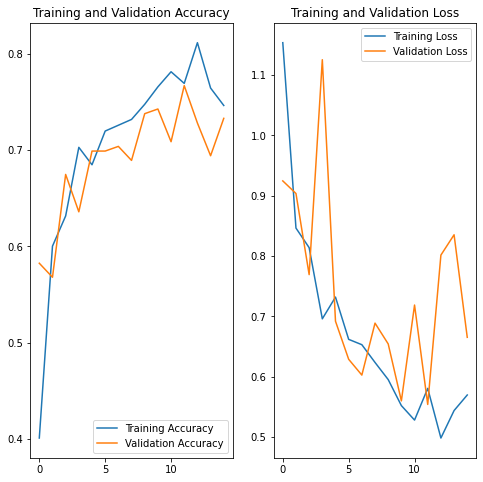

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Dapat diperhatikan hasil perbaikan plot lebih baik dari sebelumnya 

Memasukkan data test untuk diprediksi

In [ ]:
dataset_url2 = "https://storage.googleapis.com/ibeans/test.zip"
data_dir2 = tf.keras.utils.get_file(origin=dataset_url2, extract=True, archive_format='zip')

17708541/17708541 [==============================] - 0s 0us/step


In [ ]:
data_dir2 = '/root/.keras/datasets/test'
data_dir2 = pathlib.Path(data_dir2)

In [ ]:
print(data_dir2)

/root/.keras/datasets/test


In [ ]:
print(type(data_dir2))

<class 'pathlib.PosixPath'>


In [ ]:
# jumlah instance dataset
image_count = len(list(data_dir2.glob('*/*.jpg')))
print(image_count)

128


In [ ]:
ls  /root/.keras/datasets/ # Untuk memeriksa apakah data sudah tersimpan di cloud

test/  test.zip  train/  train.zip


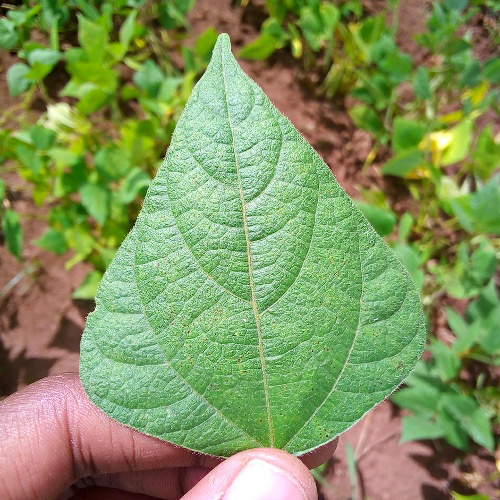

In [ ]:
new_data = list(data_dir2.glob('healthy/*')) # memeriksa salah satu gambar dari data test pada folder healthy
PIL.Image.open(str(new_data[0]))

In [ ]:
new_image = new_data[0] #untuk mengambil foto baru

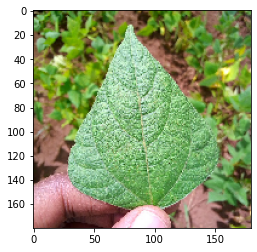

In [ ]:
img = tf.keras.utils.load_img(
    new_image, target_size=(img_height, img_width)
)
plt.imshow(img) #menampilkan gambar yg dipilih

Melakukan proses prediksi pada foto salah satu jenis daun buncis, apakah mempunyai penyakit(bean_rust / angular_leaf_spot) atau sehat (healthy)

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 137ms/step
This image most likely belongs to healthy with a 99.74 percent confidence.


Dari proses prediksi pada gambar sebelumnya yang dilakukan, diperoleh hasil bahwa gambar tersebut masuk ke dalam kelas "healthy" dengan percent confidence sebesar **99.74**. Hal ini menunjukkan bahwa prediksi benar dan hampir menyentuh percent confidence 100%. Tetapi, percent confidence ini dapat mengalami perubahan (apabila di *re-run*), dikarenakan pengambilan data random (tidak di-label) yang termasuk unsupervised learning, sehingga percent confidence dapat mengalami perubahan walaupun tidak secara signifikan. 